# Regression and Classification with Fully Connected Neural Networks

Deep learning is a large, developing field with many sub-communities, a constant stream of new developments, and unlimited application areas. Despite this complexity, most deep learning techniques share a relatively small set of algorithmic building blocks. The purpose of this notebook is to gain familiarity with some of these core concepts. Much of the intuition you develop here is applicable to the neural networks making headline news from the likes of OpenAI. To focus this notebook, we will consider the two main types of supervised machine learning:
1. Regression: estimation of continuous quantities
2. Classification: estimation of categories or discrete quantities

We will create "deep learning" models for regression and classification. We will see the power of neural networks as well as the pitfalls. 

In [1]:
# libraries we will need
import torch
from torch import nn
import numpy as np
from torch.distributions import bernoulli
import matplotlib.pyplot as plt

# set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Tasks to solve in this notebook

### Regression

In [2]:
# make some fake regression data
n_samples_reg = 100
x_reg = 1.5*torch.randn(n_samples_reg, 1)
y_reg = 2 * x_reg + 3.0*torch.sin(3*x_reg) + 1 + 2 * torch.randn(n_samples_reg, 1)
y_reg = y_reg.squeeze()

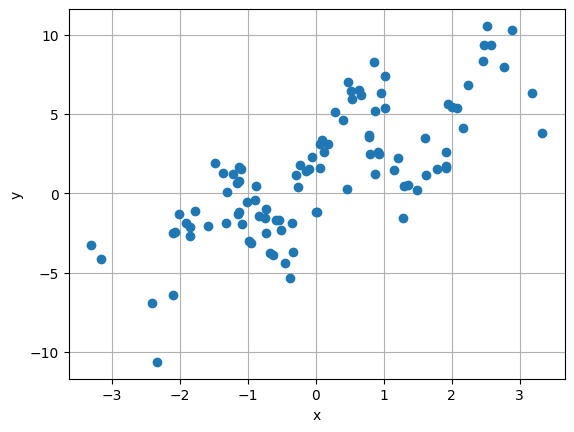

In [3]:
plt.plot(x_reg, y_reg, 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

### Classification

In [4]:
# fake classification data
n_samples_clf = 200
x_clf = 2.5*torch.randn(n_samples_clf, 2)
d = torch.sqrt( x_clf[:, 0]**2 +  x_clf[:, 1]**2 )
y_clf = (torch.sin(d) > 0) & (d<torch.pi)

# swap some labels near the boundary
width = 0.7
pgivd = 0.3 * width**2 / ((d - torch.pi)**2 + width**2)
swaps = bernoulli.Bernoulli(pgivd).sample().type(torch.bool)
y_clf[swaps] = ~y_clf[swaps]

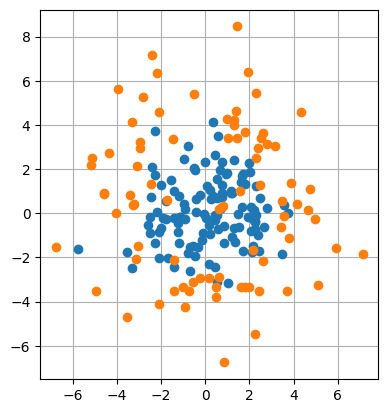

In [5]:
plt.plot(x_clf[y_clf, 0], x_clf[y_clf,1], 'o', label='positive')
plt.plot(x_clf[~y_clf, 0], x_clf[~y_clf,1], 'o', label='negative')
plt.gca().set_aspect(1)
plt.grid()

## The Simplest "Deep Learning" Model: Linear Regression

### Initializing our model

Good old fashioned linear model: $y = wx + b$. 

In [6]:
# Pytorch's `nn` module has lots of neural network building blocks
# nn.Linear is what we need for y=wx+b
reg_model = nn.Linear(in_features = 1, out_features = 1)

<div class="admonition-main-idea admonition">
<p class="admonition-title">Question</p>
<p>What do you think the arguments `in_features` and `out_features` mean? When might they not be 1?</p>
</div>

In [7]:
# pytorch randomly initializes the w and b
reg_model.weight, reg_model.bias

(Parameter containing:
 tensor([[-0.8761]], requires_grad=True),
 Parameter containing:
 tensor([-0.5502], requires_grad=True))

In [8]:
# let's look at some predictions
with torch.no_grad():
    y_reg_init = reg_model(x_reg)
    
y_reg_init[:5]

tensor([[-3.0825],
        [-2.5047],
        [-1.7339],
        [ 2.2167],
        [-1.4418]])

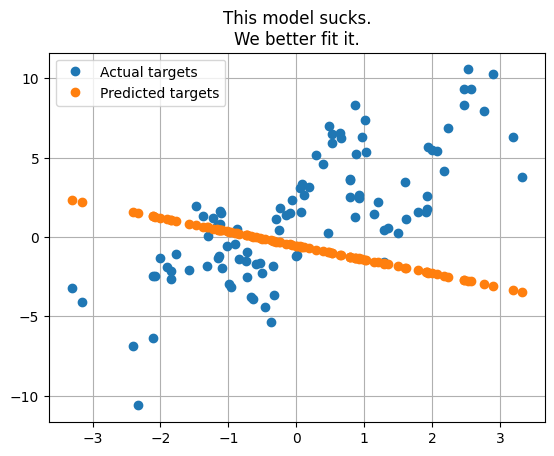

In [9]:
# plot the predictions before training the model
plt.plot(x_reg, y_reg, 'o', label='Actual targets')
plt.plot(x_reg, y_reg_init, 'o', label='Predicted targets')
plt.grid()
plt.legend()
_ = plt.title("This model sucks.\nWe better fit it.")

### Anatomy of a training loop

Basic idea: 
* Start with random parameter values
* Define a loss/cost/objective measure to optimize
* Use training data to evaluate the loss
* Update the model to reduce the loss (use gradient descent)
* Repeat until converged

Basic weight update formula: 
$
w_{i+1} = w_i - \mathrm{lr}\times \left.\frac{\partial L}{\partial w}\right|_{w=w_i}
$

<div class="admonition-main-idea admonition">
<p class="admonition-title">Question</p>
<p>Why the minus sign in front of the second term?</p>
</div>

<img src="https://github.com/clemsonciti/rcde_workshops/raw/master/pytorch/fig_grad_descent.png" alt="grad descent" width="500"/>


Epoch 1. MSE Loss = 24.350
Epoch 21. MSE Loss = 9.776
Epoch 41. MSE Loss = 7.300
Epoch 61. MSE Loss = 6.871
Epoch 81. MSE Loss = 6.793


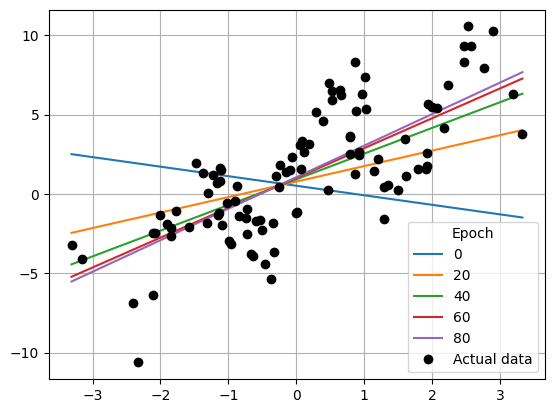

In [10]:
# re-initialize our model each time we run this cell
# otherwise the model picks up from where it left off
reg_model = nn.Linear(in_features = 1, out_features = 1)

# the torch `optim` module helps us fit models
import torch.optim as optim

# create our optimizer object and tell it about the parameters in our model
# the optimizer will be responsible for updating these parameters during training
optimizer = optim.SGD(reg_model.parameters(), lr=0.01)

# how many times to update the model based on the available data
num_epochs = 100
for i in range(num_epochs):
    # make sure gradients are set to zero on all parameters
    # by default, gradients accumulate
    optimizer.zero_grad()
    
    # "forward pass"
    y_hat = reg_model(x_reg).squeeze()
    
    # measure the loss
    # this is the mean squared error
    loss = torch.mean((y_hat - y_reg)**2)
    # can use pytorch built-in: https://pytorch.org/docs/stable/generated/torch.nn.functional.mse_loss.html
    
    # "backward pass"
    # that is, compute gradient of loss wrt all parameters
    loss.backward()
    
    # parameter updates
    # use the basic weight update formula given above (with slight modifications)
    optimizer.step()
    
    if i % 20 == 0:
        print(f"Epoch {i+1}. MSE Loss = {loss:0.3f}")
        with torch.no_grad():
            y_reg_init = reg_model(x_reg)
        
        ix = x_reg.argsort(axis=0).squeeze()
        plt.plot(x_reg.squeeze()[ix], y_reg_init.squeeze()[ix], '-', label=i, alpha=1)


plt.plot(x_reg, y_reg, 'ok', label="Actual data")
plt.grid()
_ = plt.legend(title='Epoch')

<div class="admonition-main-idea admonition">
<p class="admonition-title">Question</p>
<p> What shortcomings does this model have?  </p>
</div>

<div class="admonition-main-idea admonition">
<p class="admonition-title">🔥 IMPORTANT CONCEPT 🔥</p>
<p> Model bias is a type of error that occurs when your model doesn't have enough flexibility to represent the real-world data! </p>
</div>

## Linear classification

### A slight modification to the model

We need to modify our model because the outputs are true/false

In [11]:
y_clf.unique()

tensor([False,  True])

While training the model, we cannot simply threshold the model outputs (e.g. call outputs greater than 0 'True'). Instead, we can have our model output a continuous number between 0 and 1. Use sigmoid to transform the output of a linear model to the range (0,1):
$$
p(y=1 | \vec{x}) = \mathrm{sigmoid}(\vec w \cdot \vec x + b)
$$

<div class="admonition-main-idea admonition">
<p class="admonition-title">Question</p>
<p> Why doesn't thresholding work while training?  </p>
</div>

<div class="admonition-main-idea admonition">
<p class="admonition-title">🔥 IMPORTANT CONCEPT 🔥</p>
<p> In order to use gradient descent, neural networks must be differentiable.  </p>
</div>

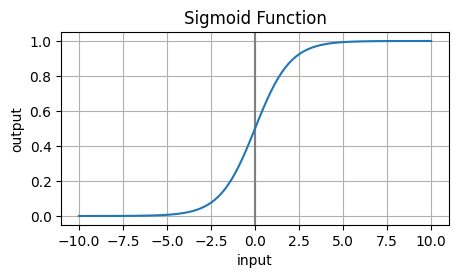

In [12]:
# what is sigmoid?
x_plt = torch.linspace(-10,10, 100)
y_plt = torch.sigmoid(x_plt)
plt.axvline(0, color='gray')
plt.plot(x_plt, y_plt)
plt.grid()
plt.xlabel('input')
plt.ylabel('output')
plt.gcf().set_size_inches(5,2.5)
_ = plt.title('Sigmoid Function')

In [13]:
# proposed new model for classification
# use nn.Sequential to string operations together
model_clf = nn.Sequential(
    nn.Linear(2, 1), # notice: we now have two inputs
    nn.Sigmoid()  # sigmoid squishes real numbers into (0, 1)
)

In [14]:
# what do the outputs look like?
with torch.no_grad():
    print(model_clf(x_clf)[:10])
# notice how they all lie between 0 and 1
    
# we loosely interpret these numbers as
# "the probability that y=1 given the provided value of x"

tensor([[0.6701],
        [0.8487],
        [0.7813],
        [0.4899],
        [0.8440],
        [0.2253],
        [0.3412],
        [0.4453],
        [0.4484],
        [0.5387]])


In [15]:
# turning probabilities into "decisions"
# apply a threshold
with torch.no_grad():
    print(model_clf(x_clf)[:10] > 0.5)

tensor([[ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True]])


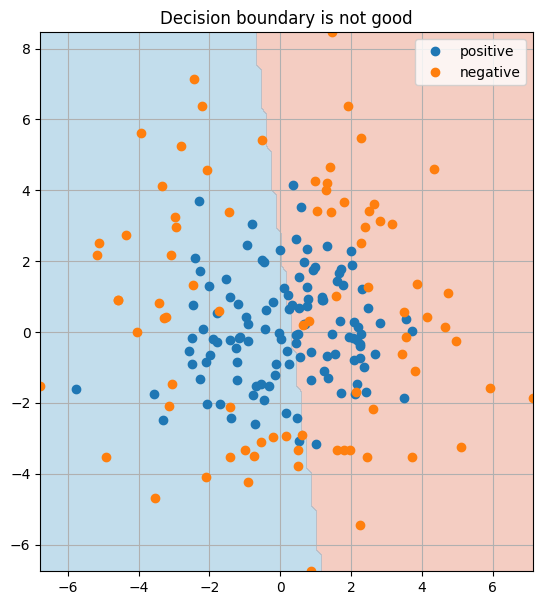

In [16]:
# let's see how this model does before any training

# Code to plot the decision regions
x_clf.min(), x_clf.max()
xx, yy = mg = torch.meshgrid(
    torch.linspace(x_clf[:,0].min(), x_clf[:,0].max(), 100),
    torch.linspace(x_clf[:,1].min(), x_clf[:,1].max(), 100)
)
grid_pts = torch.vstack([xx.ravel(), yy.ravel()]).T

with torch.no_grad():
    # use a 0.5 decision threshold
    grid_preds = model_clf(grid_pts).squeeze()>0.5

grid_preds = grid_preds.reshape(xx.shape)

plt.gcf().set_size_inches(7,7)
plt.plot(x_clf[y_clf, 0], x_clf[y_clf,1], 'o', label='positive')
plt.plot(x_clf[~y_clf, 0], x_clf[~y_clf,1], 'o', label='negative')
plt.gca().set_aspect(1)
plt.grid()
plt.contourf(xx, yy, grid_preds, cmap=plt.cm.RdBu, alpha=0.4)
plt.legend()
_ = plt.title("Decision boundary is not good")

### Training loop

The main difference between regression and classification is the loss function. For regression, we used mean squared error. For classification, we will use cross-entropy loss. This loss formula encourages the model to output low values for $p(y=1|x)$ when the class is 0 and high values when the class is 1. 

In [17]:
# re-initialize our model each time we run this cell
# otherwise the model picks up from where it left off
model_clf = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

# create our optimizer object and tell it about the parameters in our model
optimizer = optim.SGD(model_clf.parameters(), lr=0.01)

# torch needs the class labels to be zeros and ones, not False/True
y_clf_int = y_clf.type(torch.int16)

# how many times to update the model based on the available data
num_epochs = 1000
for i in range(num_epochs):
    optimizer.zero_grad()
    
    y_hat = model_clf(x_clf).squeeze()
    
    # measure the goodness of fit
    # need to use a different loss function here
    # this is the "cross entropy loss"
    loss = -y_clf_int * torch.log(y_hat) - (1-y_clf_int)*torch.log(1-y_hat)
    loss = loss.mean()
    # pytorch built-in: https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html
    
    # update the model
    loss.backward() # gradient computation
    optimizer.step()  # weight updates
    
    if i % 100 == 0:
        print(f"Epoch {i+1}. MSE Loss = {loss:0.3f}")

Epoch 1. MSE Loss = 0.959
Epoch 101. MSE Loss = 0.774
Epoch 201. MSE Loss = 0.727
Epoch 301. MSE Loss = 0.705
Epoch 401. MSE Loss = 0.691
Epoch 501. MSE Loss = 0.683
Epoch 601. MSE Loss = 0.678
Epoch 701. MSE Loss = 0.675
Epoch 801. MSE Loss = 0.673
Epoch 901. MSE Loss = 0.672


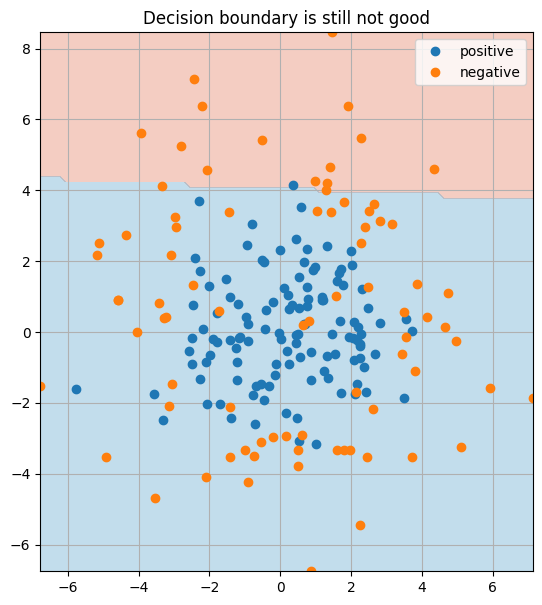

In [18]:
with torch.no_grad():
    # use a 0.5 decision threshold
    grid_preds = model_clf(grid_pts).squeeze()>0.5

grid_preds = grid_preds.reshape(xx.shape)

plt.gcf().set_size_inches(7,7)
plt.plot(x_clf[y_clf, 0], x_clf[y_clf,1], 'o', label='positive')
plt.plot(x_clf[~y_clf, 0], x_clf[~y_clf,1], 'o', label='negative')
plt.gca().set_aspect(1)
plt.grid()
plt.contourf(xx, yy, grid_preds, cmap=plt.cm.RdBu, alpha=0.4)
plt.legend()
_ = plt.title("Decision boundary is still not good")

<div class="admonition-main-idea admonition">
<p class="admonition-title">Question</p>
<p>  Why did this experiment fail? Any ideas what we could do to make it work?  </p>
</div>

### Summing up linear models

Sometimes linear models can be a good approximation to our data. Sometimes not. 

Linear models tend to be _biased_ in the statistical sense of the word. That is, they enforce linearity in the form of linear regression lines or linear decision boundaries. The linear model will fail to the degree that the real-world data is non-linear. 

## Getting non-linear with fully-connected neural networks

We can compose simple math operations together to represent very complex functions.

<img src="https://github.com/clemsonciti/rcde_workshops/raw/master/pytorch/fig_ann.png" alt="grad descent" width="500"/>

### A few helper functions

In [19]:
def train_and_test_regression_model(model, num_epochs=1000, reporting_interval=100):

    # create our optimizer object and tell it about the parameters in our model
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # how many times to update the model based on the available data
    for i in range(num_epochs):
        optimizer.zero_grad()

        y_hat = model(x_reg).squeeze()

        # measure the goodness of fit
        loss = torch.mean((y_hat - y_reg)**2)

        # update the model
        loss.backward() # gradient computation
        optimizer.step()  # weight updates

        if i % reporting_interval == 0:
            print(f"Epoch {i+1}. MSE Loss = {loss:0.3f}")
            
    with torch.no_grad():
        y_reg_init = model(x_reg)
    plt.plot(x_reg.cpu(), y_reg.cpu(), 'o', label='Actual targets')
    plt.plot(x_reg.cpu(), y_reg_init.cpu(), 'x', label='Predicted targets')
    plt.grid()
    plt.legend()

In [20]:
def train_and_test_classification_model(model, num_epochs=1000, reporting_interval=100):

    # create our optimizer object and tell it about the parameters in our model
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # how many times to update the model based on the available data
    for i in range(num_epochs):
        optimizer.zero_grad()

        y_hat = model(x_clf).squeeze()

        # measure the goodness of fit
        # need to use a different loss function here
        loss = -y_clf_int * torch.log(y_hat) - (1-y_clf_int)*torch.log(1-y_hat)
        loss = loss.mean()

        # update the model
        loss.backward() # gradient computation
        optimizer.step()  # weight updates
    
        if i % reporting_interval == 0:
            print(f"Epoch {i+1}. MSE Loss = {loss:0.3f}")   
            
    with torch.no_grad():
        grid_preds = model(grid_pts).squeeze()>0.5

    grid_preds = grid_preds.reshape(xx.shape)

    plt.gcf().set_size_inches(7,7)
    plt.plot(x_clf[y_clf, 0], x_clf[y_clf,1], 'o', label='positive')
    plt.plot(x_clf[~y_clf, 0], x_clf[~y_clf,1], 'o', label='negative')
    plt.gca().set_aspect(1)
    plt.grid()
    plt.contourf(xx, yy, grid_preds, cmap=plt.cm.RdBu, alpha=0.4)
    plt.legend()

### Regression

What about nested linear models? Might this do something interesting? 
$$
y = w_1(w_0 x + b_0) + b_1
$$

Epoch 1. MSE Loss = 16.093
Epoch 101. MSE Loss = 6.771
Epoch 201. MSE Loss = 6.771
Epoch 301. MSE Loss = 6.771
Epoch 401. MSE Loss = 6.771
Epoch 501. MSE Loss = 6.771
Epoch 601. MSE Loss = 6.771
Epoch 701. MSE Loss = 6.771
Epoch 801. MSE Loss = 6.771
Epoch 901. MSE Loss = 6.771


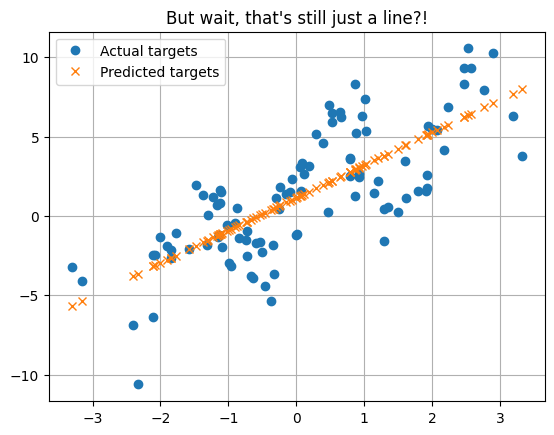

In [21]:
# We can build more complex models by stringing together more operations inside nn.Sequential:
model =  nn.Sequential(
    nn.Linear(in_features = 1, out_features = 1),
    nn.Linear(1,1)
)

train_and_test_regression_model(model)
_ = plt.title("But wait, that's still just a line?!")

<div class="admonition-main-idea admonition">
<p class="admonition-title">Question</p>
<p> Why is it still just a line? How can we fix it?  </p>
</div>

Epoch 1. MSE Loss = 15.631
Epoch 101. MSE Loss = 7.572
Epoch 201. MSE Loss = 7.014
Epoch 301. MSE Loss = 6.965
Epoch 401. MSE Loss = 6.940
Epoch 501. MSE Loss = 6.922
Epoch 601. MSE Loss = 6.907
Epoch 701. MSE Loss = 6.896
Epoch 801. MSE Loss = 6.887
Epoch 901. MSE Loss = 6.880


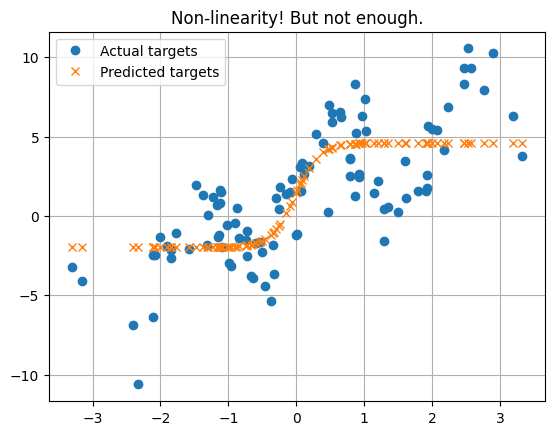

In [22]:
# We need a non-linearity between the two linear operations
model =  nn.Sequential(
    nn.Linear(in_features = 1, out_features = 1),
    nn.Tanh(),
    nn.Linear(1,1)
)
# this model does not reduce to a linear operation

train_and_test_regression_model(model)
_ = plt.title("Non-linearity! But not enough.")

Epoch 1. MSE Loss = 17.355
Epoch 5001. MSE Loss = 2.136
Epoch 10001. MSE Loss = 1.604
Epoch 15001. MSE Loss = 1.451
Epoch 20001. MSE Loss = 1.072
Epoch 25001. MSE Loss = 1.222
Epoch 30001. MSE Loss = 0.997
Epoch 35001. MSE Loss = 0.880
Epoch 40001. MSE Loss = 0.940
Epoch 45001. MSE Loss = 0.741


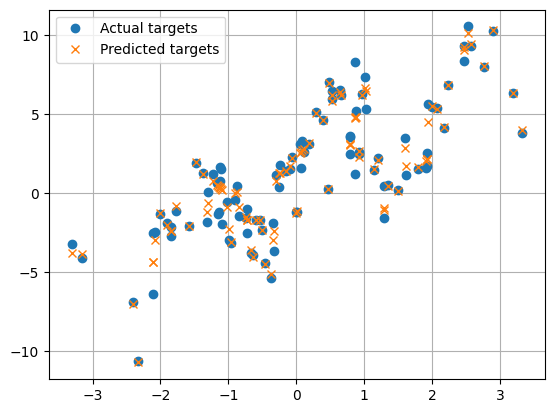

In [23]:
# Let's really crank up the number of hidden nodes
model =  nn.Sequential(
    nn.Linear(in_features = 1, out_features = 30),
    nn.Tanh(),
    nn.Linear(30,30),
    nn.Tanh(),
    nn.Linear(30,30),
    nn.Tanh(),
    nn.Linear(30,30),
    nn.Tanh(),
    nn.Linear(30,30),
    nn.Tanh(),
    nn.Linear(30,30),
    nn.Tanh(),
    nn.Linear(30,1)
)

train_and_test_regression_model(model, num_epochs=50000, reporting_interval=5000)

<div class="admonition-main-idea admonition">
<p class="admonition-title">Question</p>
<p> What is wrong with this picture?  </p>
</div>

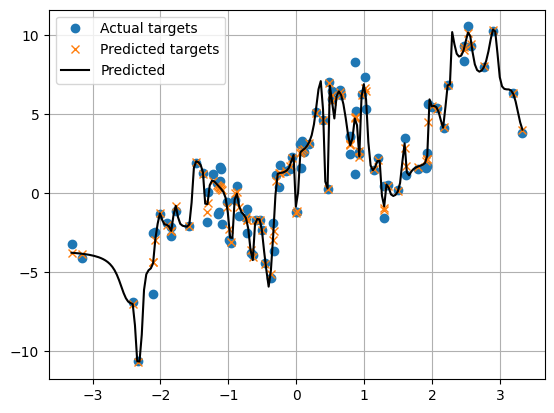

In [24]:
with torch.no_grad():
    x_grid = torch.linspace(x_reg.min(), x_reg.max(), 200)[:,None]
    y_reg_grid = model(x_grid)
    y_reg_init = model(x_reg)
plt.plot(x_reg.cpu(), y_reg.cpu(), 'o', label='Actual targets')
plt.plot(x_reg.cpu(), y_reg_init.cpu(), 'x', label='Predicted targets')
plt.plot(x_grid.cpu(), y_reg_grid.cpu(), 'k-', label='Predicted')
plt.grid()
plt.legend()

<div class="admonition-main-idea admonition">
<p class="admonition-title">Question</p>
<p> Where is overfitting most severe? How might having more data alleviate the problem?  </p>
</div>

<div class="admonition-main-idea admonition">
<p class="admonition-title">🔥 IMPORTANT CONCEPT 🔥</p>
<p> Overfitting is a type of error that occurs when your model memorizes the training samples and fails to generalize to unseen data. This usually ocurrs when the model has excess capacity.  </p>
</div>

<div class="admonition-main-idea admonition">
<p class="admonition-title">😅 EXCERCISE 😅</p>
<p> Using the code cell below, design and test a model that gets it "just right". </p>
</div>

In [25]:
#model = your model goes here

# train_and_test_regression_model(model, num_epochs=10000, reporting_interval=1000)

### Classification

Let's apply the same non-linear treatment to the case of classification.

Epoch 1. MSE Loss = 0.748
Epoch 1001. MSE Loss = 0.674
Epoch 2001. MSE Loss = 0.665
Epoch 3001. MSE Loss = 0.640
Epoch 4001. MSE Loss = 0.589
Epoch 5001. MSE Loss = 0.548
Epoch 6001. MSE Loss = 0.522
Epoch 7001. MSE Loss = 0.507
Epoch 8001. MSE Loss = 0.497
Epoch 9001. MSE Loss = 0.492


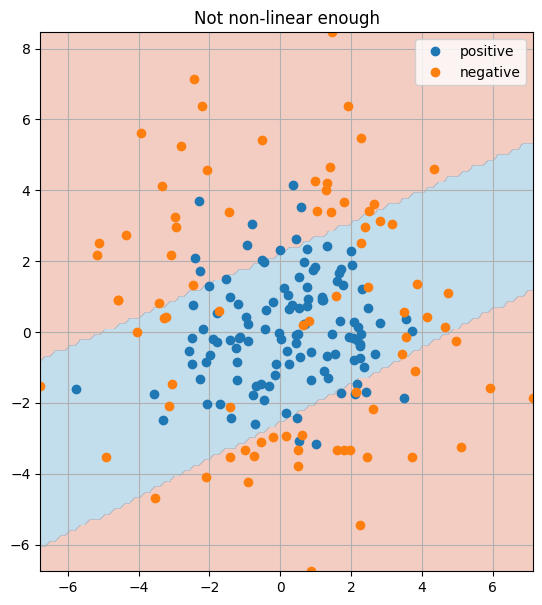

In [26]:
model =  nn.Sequential(
    nn.Linear(in_features = 2, out_features = 2),
    nn.Tanh(),
    nn.Linear(2,1),
    nn.Sigmoid()
)

train_and_test_classification_model(model, 10000, 1000)
_ = plt.title("Not non-linear enough")

<div class="admonition-main-idea admonition">
<p class="admonition-title">Question</p>
<p> What would overfitting look like in this type of graph?  </p>
</div>

Epoch 1. MSE Loss = 0.697
Epoch 3001. MSE Loss = 0.276
Epoch 6001. MSE Loss = 0.251
Epoch 9001. MSE Loss = 0.236
Epoch 12001. MSE Loss = 0.221
Epoch 15001. MSE Loss = 0.209
Epoch 18001. MSE Loss = 0.186
Epoch 21001. MSE Loss = 0.168
Epoch 24001. MSE Loss = 0.150
Epoch 27001. MSE Loss = 0.141


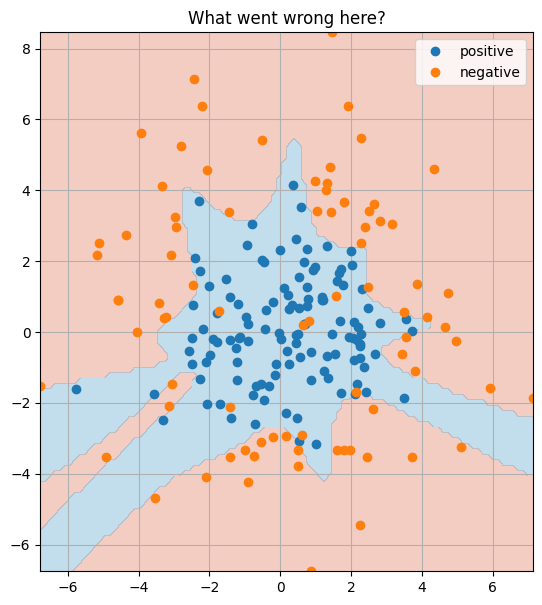

In [27]:
model =  nn.Sequential(
    nn.Linear(in_features = 2, out_features = 50),
    nn.Tanh(),
    nn.Linear(50,50),
    nn.Tanh(),
    nn.Linear(50,50),
    nn.Tanh(),
    nn.Linear(50,50),
    nn.Tanh(),
    nn.Linear(50,50),
    nn.Tanh(),
    nn.Linear(50,50),
    nn.Tanh(),
    nn.Linear(50,1),
    nn.Sigmoid()
)

train_and_test_classification_model(model, 30000, 3000)
_ = plt.title("What went wrong here?")

<div class="admonition-main-idea admonition">
<p class="admonition-title">Question</p>
<p> What's wrong with this picture? </p>
</div>

<div class="admonition-main-idea admonition">
<p class="admonition-title">😅 EXCERCISE 😅</p>
<p> Using the code cell below, design and test a model that gets it "just right". </p>
</div>

In [28]:
#model = your model goes here

# train_and_test_classification_model(model, 20000, 2000)

### Summing up fully connected neural networks
* Fully connected neural networks can represent highly non-linear functions
* We can learn good functions through gradient descent
* Overfitting is a big problem

These concepts apply to nearly any neural network trained with gradient descent from the smallest fully connected net to GPT-4. 